# Importaciones y funciones aux

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os, random

# Análisis de los datos a nivel básico

Primero, es necesario ver si las clases están balanceadas, ya que un desbalance provoca que el modelo prediga mejor las clases mayoritarias, frente a las clases minoritarias.

In [3]:
# Función para contar imágenes en un directorio
def contar_imagenes_por_carpeta(ruta_base, extensiones=("jpg", "png", "jpeg", "gif", "bmp", "tiff")):
    conteo = {}
    for carpeta, _, archivos in os.walk(ruta_base):
        num_imagenes = sum(1 for archivo in archivos if archivo.lower().endswith(extensiones))
        if carpeta != ruta_base:  # Excluir la carpeta base del conteo
            nombre_carpeta = os.path.basename(carpeta)
            conteo[nombre_carpeta] = num_imagenes
    return conteo

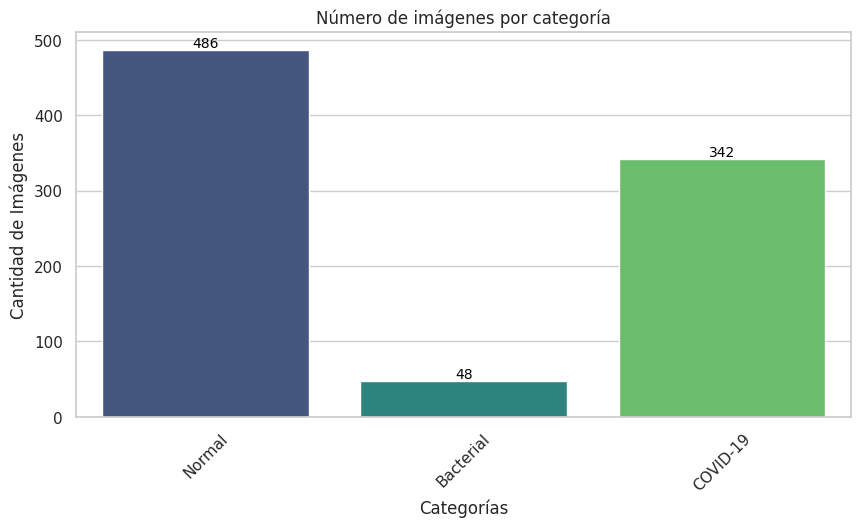

,Categoría,Instancias,Porcentaje
0,Normal,486,55.479452
1,Bacterial,48,5.479452
2,COVID-19,342,39.041096


In [ ]:
# Ruta donde están las imágenes (ajustar según necesidad)
ruta_directorio = "./data/covid-chest-xray"

# Contar imágenes
conteo_imagenes = contar_imagenes_por_carpeta(ruta_directorio)

df = pd.DataFrame(list(conteo_imagenes.items()), columns=["Categoría", "Instancias"])
df["Porcentaje"] = (df["Instancias"] / df["Instancias"].sum()) * 100

# Graficar
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, x="Categoría", y="Instancias", hue="Categoría", legend=False, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Categorías")
plt.ylabel("Cantidad de Imágenes")
plt.title("Número de imágenes por categoría")

# Mostrar valores en las barras
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=10, color="black")

plt.show()

df

Se observa un claro desbalanceo. Para el primer problema binario (sano y enfermo) no debería haber ningún problema, aunque sería conveniente subir un poco la muestra de neumonía. En cambio, el segundo problema (sano, neumonía y covid), neumonía es una clase minoritaria, dificultando la tarea de predecir en caso de neumonía. Es por ello, se realizará un data augmentation para poder equilibrar este desbalance.

# Data Augmentation

Para el data augmentation, se realizan diferentes filtros:
  - **`rotation_range`**: Rotación aleatoria en grados.
  - **`width_shift_range`**: Desplazamiento horizontal aleatorio.
  - **`height_shift_range`**: Desplazamiento vertical aleatorio.
  - **`zoom_range`**: Zoom aleatorio en el rango indicado.
  - **`brightness_range`**: Ajuste de brillo aleatorio entre los valores indicados.
  - **`horizontal_flip`**: Voltea horizontalmente las imágenes de forma aleatoria.
  - **`fill_mode='nearest'`**: Rellena píxeles vacíos tras la transformación con valores cercanos.

Se comprueba que la función creada realice los filtros aplicados.

In [5]:
def create_data_generator(is_not_balanced=False):
    # En caso de no estar balanceado, es más agresivo el ruido aplicado
    if is_not_balanced:
        return ImageDataGenerator(
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.3,
            brightness_range=[0.7, 1.3],
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        return ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            brightness_range=[0.8, 1.2],
            horizontal_flip=True,
            fill_mode='nearest'
        )

In [ ]:
# Directorios del dataset (modificar según la estructura)
data_dir = './data/covid-chest-xray/'
batch_size = 32
img_size = (224, 224)  # Ajustable según el modelo

# Generadores de imágenes
datagen = create_data_generator()
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Para clasificación multiclase
)

Found 876 images belonging to 3 classes.


In [7]:
def show_filter_effect(generator, class_images, filter_name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.suptitle(f"Filtro aplicado: {filter_name}", fontsize=14)

    for i, (class_name, img_path) in enumerate(class_images.items()):
        image = load_img(img_path, target_size=(224, 224), color_mode='grayscale')
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)  # Expandir dimensiones para usar con el generador

        # Aplicar el filtro
        augmented_image = generator.flow(image_array, batch_size=1)[0]

        # Mostrar la imagen
        axes[i].imshow(augmented_image.squeeze(), cmap='gray')
        axes[i].set_title(class_name)
        axes[i].axis('off')

    plt.show()

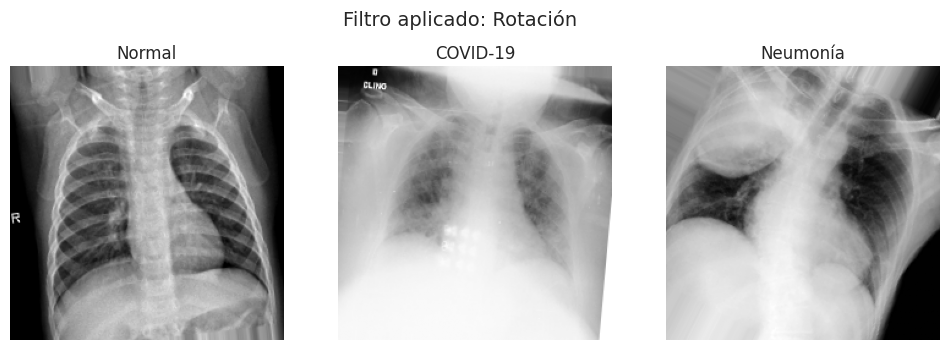

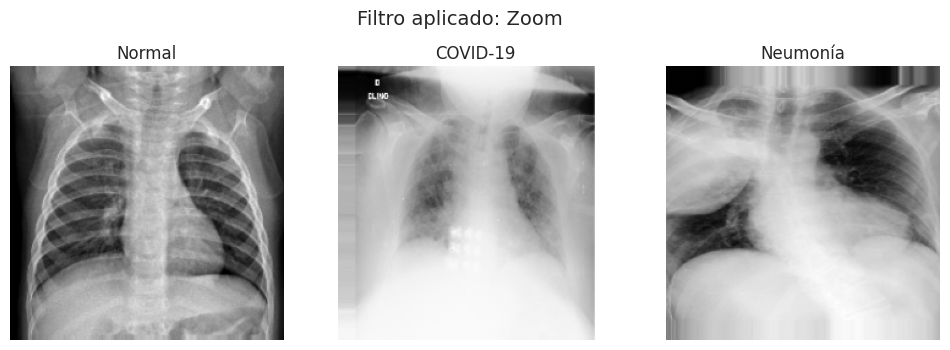

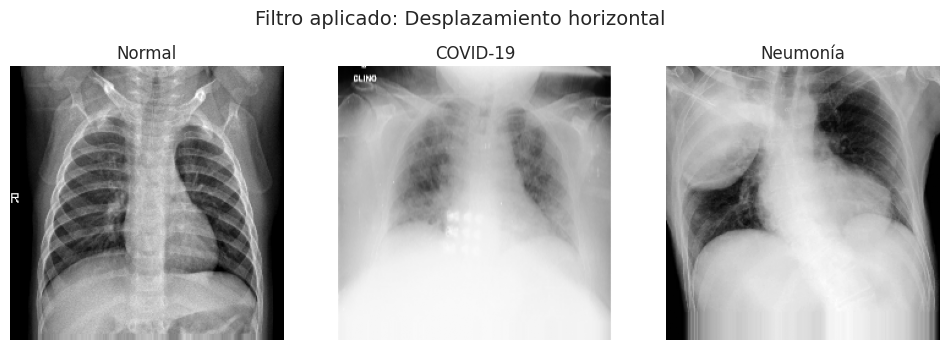

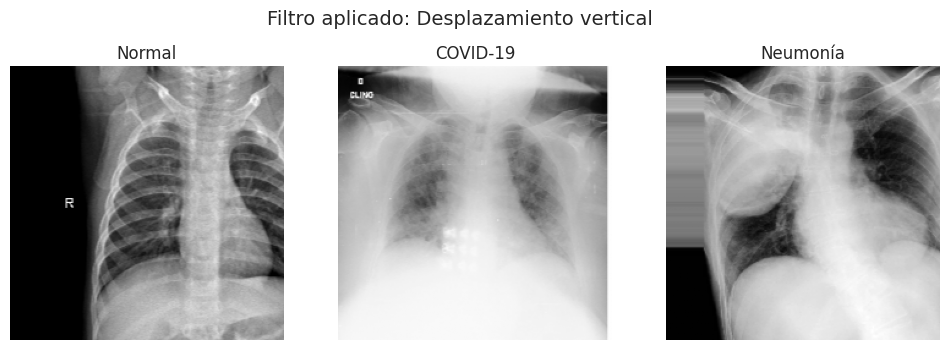

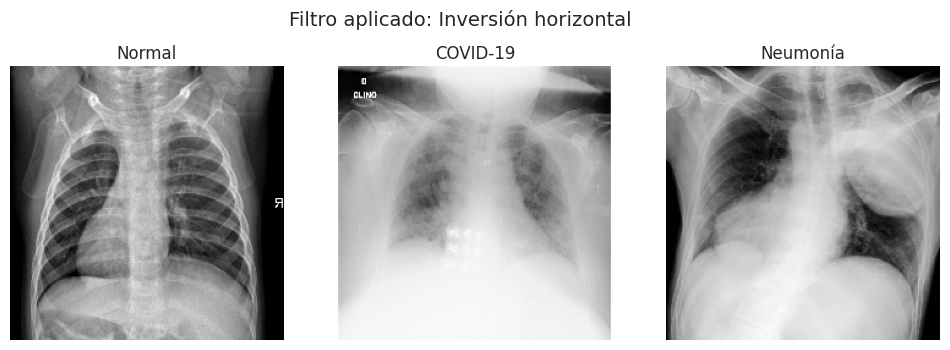

In [ ]:
# Crear un generador con Data Augmentation
augment_generator = create_data_generator()

# Rutas de imágenes de ejemplo (asegúrate de cambiar estos paths a imágenes existentes en tu dataset)
example_images = {
    'Normal': './data/covid-chest-xray/Normal/Normal-1.jpeg',
    'COVID-19': './data/covid-chest-xray/COVID-19/COVID-19-1.jpeg',
    'Neumonía': './data/covid-chest-xray/Bacterial/Bacterial-1.jpg'
}

# Aplicar diferentes filtros y mostrar resultados
filter_generators = {
    "Rotación": ImageDataGenerator(rotation_range=30),
    "Zoom": ImageDataGenerator(zoom_range=0.2),
    "Desplazamiento horizontal": ImageDataGenerator(width_shift_range=0.2),
    "Desplazamiento vertical": ImageDataGenerator(height_shift_range=0.2),
    "Inversión horizontal": ImageDataGenerator(horizontal_flip=True)
}

for filter_name, generator in filter_generators.items():
    show_filter_effect(generator, example_images, filter_name)

# Creación del dataset con Data Augmentation

Para este dataset nuevo, se generarán 500 imágenes de las clases mayoritarias (sano y COVID-19) y 1000 imágenes de las clases minoritarias (neumonía). A partir de aquí se mezclarán en la siguiente etapa, a la hora de realizar los conjuntos de entrenamiento y test, al igual que el conjunto de validación.

In [9]:
# Función para generar aumentaciones aleatorias
def get_random_augmentation():
    return {
        'rotation_range': random.choice([0, 10, 15, 25]),
        'width_shift_range': random.choice([0.0, 0.1, 0.2]),
        'height_shift_range': random.choice([0.0, 0.1, 0.2]),
        'zoom_range': random.choice([0.0, 0.2, 0.3]),
        'brightness_range': random.choice([[1.0, 1.0], [0.8, 1.2], [0.7, 1.3]]),
        'horizontal_flip': random.choice([False, True])
    }

# Generación de imágenes aumentadas
def generate_augmented_images(class_name, num_images, data_dir):
    class_dir = os.path.join(data_dir, class_name + '/')
    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]

    generated_count = 0
    used_combinations = {}

    while generated_count < num_images:
        # Seleccionar imagen original aleatoria
        img_path = random.choice(images)
        img = load_img(img_path, target_size=img_size, color_mode='grayscale')
        img_array = img_to_array(img)

        # Inicializar el historial de combinaciones si es la primera vez que se usa la imagen
        if img_path not in used_combinations:
            used_combinations[img_path] = []

        # Generar una combinación de augmentación única para esta imagen
        while True:
            aug_config = get_random_augmentation()
            aug_tuple = sorted(aug_config.items())  # Convertir a tupla para ser hashable

            if aug_tuple not in used_combinations[img_path]:
                used_combinations[img_path].append(aug_tuple)
                break  # Salimos del bucle cuando encontramos una combinación nueva

        # Aplicar la transformación específica
        datagen = ImageDataGenerator(**aug_config)
        augmented_img = datagen.random_transform(img_array)

        # Guardar la imagen aumentada
        output_path = os.path.join(output_dir, class_name, f'augmentated-{class_name}-{generated_count}.jpg')
        array_to_img(augmented_img).save(output_path)
        generated_count += 1

        if generated_count % 50 == 0:
            print(f"{generated_count} imágenes generadas para {class_name}...")

In [ ]:
output_dir = './data/data_augmentation'
classes = ['Normal', 'COVID-19', 'Bacterial']

for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

batch_size = 32
img_size = (224, 224)

# Número de imágenes a generar
num_images_to_generate = {'Normal': 500, 'COVID-19': 500, 'Bacterial': 1000}
counters = {'Normal': 0, 'COVID-19': 0, 'Bacterial': 0}

# Generación de imágenes balanceadas
for cls in classes:
    print(f"Generando imágenes para la clase: {cls}")
    generate_augmented_images(cls, num_images_to_generate[cls], data_dir)

print("Generación de imágenes aumentadas finalizada.")

Generando imágenes para la clase: Normal
50 imágenes generadas para Normal...
100 imágenes generadas para Normal...
150 imágenes generadas para Normal...
200 imágenes generadas para Normal...
250 imágenes generadas para Normal...
300 imágenes generadas para Normal...
350 imágenes generadas para Normal...
400 imágenes generadas para Normal...
450 imágenes generadas para Normal...
500 imágenes generadas para Normal...
Generando imágenes para la clase: COVID-19
50 imágenes generadas para COVID-19...
100 imágenes generadas para COVID-19...
150 imágenes generadas para COVID-19...
200 imágenes generadas para COVID-19...
250 imágenes generadas para COVID-19...
300 imágenes generadas para COVID-19...
350 imágenes generadas para COVID-19...
400 imágenes generadas para COVID-19...
450 imágenes generadas para COVID-19...
500 imágenes generadas para COVID-19...
Generando imágenes para la clase: Bacterial
50 imágenes generadas para Bacterial...
100 imágenes generadas para Bacterial...
150 imágenes 